In [1]:
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import uproot
import pandas as pd
import awkward as ak
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow_decision_forests as tfdf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from keras.callbacks import LearningRateScheduler

2022-12-09 14:28:20.284358: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 14:28:21.645783: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/benk/root/root-6.26.10-install/lib
2022-12-09 14:28:21.645841: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-09 14:28:25.831748: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cann

In [2]:
def open_root_files(file_names,tree):
    file = uproot.open(file_names)
    tree_name = file[tree]
    return tree_name

def create_heat_map(df):
    corr = df.corr()
    sns.heatmap(corr, 
    cmap='RdYlGn', 
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values)
    plt.show()

def create_tensor_object(train_variables,dict):
    df = pd.DataFrame()
    key = list(dict.keys())[0]

    for var in train_variables:
        if(var == "classification"):
            continue
        else:
            varDf = dict[key][var].array(library = 'pd')
            if(varDf.index.nlevels == 2):
                df[var] = varDf.reset_index(level=1, drop=True)
            else:
                df[var] = varDf

    if "signal" in key:
        print("SIGNAL CLASSIFICATION SET TO 1", key)
        df.insert(0, 'classification', 1)
    else:
        print("BACKGROUND CLASSIFICATION SET TO 0", key)
        df.insert(0, 'classification', 0)
    
    #split the data into train and testing set
    train_df, test_df = train_test_split(df, test_size=0.2)
    
    train_df, val_df = train_test_split(train_df, test_size=0.2)
    
    train_df.filter(train_df['weight'] > 0)
    test_df.filter(test_df['weight'] > 0)
    val_df.filter(val_df['weight'] > 0)
    
    train_df_class = train_df.pop('classification')
    train_df_weights = train_df.pop('weight')
    test_df_class = test_df.pop('classification')
    test_df_weights = test_df.pop('weight')
    val_df_class = val_df.pop('classification')
    val_df_weights = val_df.pop('weight')

    #create heat map of training variables
    hmap = create_heat_map(train_df)
    
    return train_df, train_df_class, train_df_weights, test_df, test_df_class, test_df_weights, val_df, val_df_class, val_df_weights

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
def plot_loss(fit):
    plt.plot(fit.history['loss'])
    plt.plot(fit.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_accuracy(fit):
    plt.plot(fit.history['accuracy'])
    plt.plot(fit.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def custom_LearningRate_schedular(epoch):
    if epoch < 5:
        return 0.01
    else:
        return 0.01 * tf.math.exp(0.1 * (10 - epoch))

    
def get_model(metric, bias, train_tensor):
    model = keras.Sequential([
    keras.layers.Dense(4, activation='relu', input_shape=(train_tensor.shape[1],), bias_initializer=keras.initializers.Constant(bias)),
    # keras.layers.Dense(128, activation='relu'),
    # keras.layers.Dense(128, activation='relu'),
    # keras.layers.Dense(128, activation='relu'),
    # keras.layers.Dense(128, activation='relu'),
    # keras.layers.Dense(64, activation='relu'),
    # keras.layers.Dense(64, activation='relu'),
    # keras.layers.Dense(64, activation='relu'),
    # keras.layers.Dense(64, activation='relu'),
    # keras.layers.Dense(32, activation='relu'),
    # keras.layers.Dense(16, activation='relu'),
    # keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])
    model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001),
                loss=tf.keras.losses.BinaryCrossentropy(
                        name='binary_crossentropy'),
                metrics=[metric])
    # model.layers[0].bias.assign([bias])
    return model


def boosted_decision_tree():
    model = tfdf.keras.GradientBoostedTreesModel()
    return model

def random_forest_tree():
    model = tfdf.keras.RandomForestModel()
    return model

In [3]:
#open the files
signal_file_e = open_root_files("mc16e_signal.root","nominal")
#signal_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_signal.root","nominal")
#signal_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_signal.root","nominal")
ttbar_file_e = open_root_files("mc16e_ttbar.root","nominal")
#ttbar_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_ttbar.root","nominal")
#ttbar_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_ttbar.root","nominal")
#wjets_file_e = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16e_wjets.root","nominal")
#wjets_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_wjets.root","nominal")
#wjets_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_wjets.root","nominal")
#diboson_file_e = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16e_diboson.root","nominal")
#diboson_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_diboson.root","nominal")
#diboson_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_diboson.root","nominal")
#zjets_file_e = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16e_zjets.root","nominal")
#zjets_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_zjets.root","nominal")
#zjets_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_zjets.root","nominal")
#singletop_file_e = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16e_singletop.root","nominal")
#singletop_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_singletop.root","nominal")
#singletop_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_singletop.root","nominal")

SIGNAL CLASSIFICATION SET TO 1 signal_e


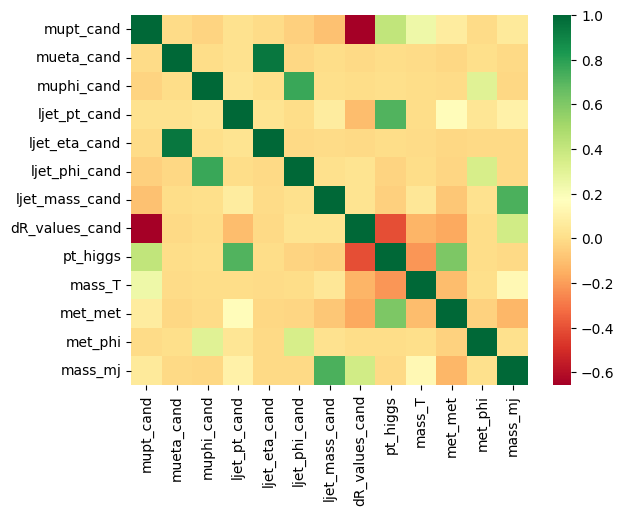

BACKGROUND CLASSIFICATION SET TO 0 ttbar_e


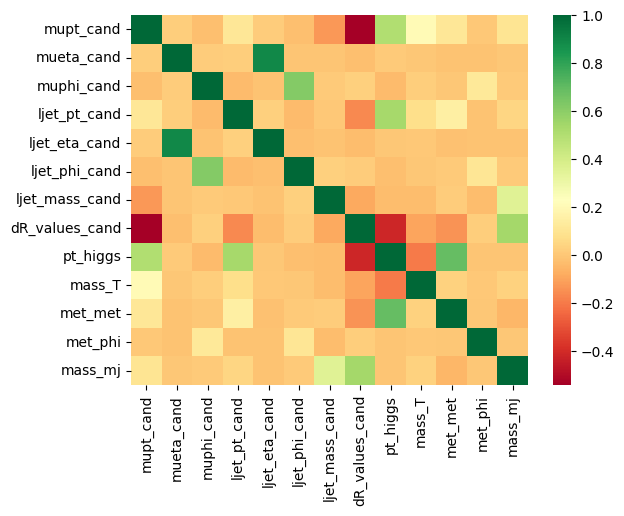

entry
1664    0.005934
1094    0.010107
627     0.009224
2844    0.003280
1561    0.020658
          ...   
2527    0.001346
275     0.007939
621     0.001534
263     0.000386
1540    0.005258
Name: weight, Length: 2124, dtype: float64
entry
3125    0.135589
2844    0.014877
663     0.171730
325     0.137468
1217    0.140447
          ...   
51      0.098470
1959    0.120026
689     0.077163
2675    0.076219
2853    0.090103
Name: weight, Length: 2259, dtype: float64
Examples:  Total: 4383  Positive: 2124  Negative: 2259  Ratio: 0.48459958932238195
[1 1 1 ... 0 0 0]
[0.00593445 0.01010745 0.00922357 ... 0.07716295 0.07621862 0.09010329]
[242.3031133  14.1948329]
Weighted Training Events:  Total: 256.4979462034286  Positive: 14.1948329029524  Negative: 242.3031133004762  Ratio: 0.05534092226880629
Weighted Test Events:  Total: 80.22069654140874  Positive: 4.5181831954569285  Negative: 75.70251334595181  Ratio: 0.05632191429707555
Weighted Validation Events:  Total: 63.21553098013684  Po

In [4]:
# variables = ['classification','mupt_cand', 'mueta_cand', 'muphi_cand', 'ljet_pt_cand', 'ljet_eta_cand',\
#                    'ljet_phi_cand', 'ljet_mass_cand', 'dR_values_cand', 'pt_higgs',\
#                    'mass_T', 'met_met', 'met_phi', 'mass_mj', 'weight']
# variables = ['classification','mupt_cand','ljet_pt_cand','ljet_mass_cand','dR_values_cand','pt_higgs','mass_T', 'met_met', 'mass_mj', 'weight']
variables = ['classification', 'mupt_cand', 'mueta_cand', 'muphi_cand', 'ljet_pt_cand', 'ljet_eta_cand',\
                   'ljet_phi_cand', 'ljet_mass_cand', 'dR_values_cand', 'pt_higgs',\
                   'mass_T', 'met_met', 'met_phi', 'mass_mj', 'weight']

signal_train_e, signal_train_class_e, signal_train_weights_e, signal_test_e, signal_test_class_e, signal_test_weights_e, signal_val_e, signal_val_class_e, signal_val_weights_e = create_tensor_object(variables, {"signal_e" : signal_file_e})
ttbar_train_e, ttbar_train_class_e, ttbar_train_weights_e, ttbar_test_e, ttbar_test_class_e, ttbar_test_weights_e, ttbar_val_e, ttbar_val_class_e, ttbar_val_weights_e  = create_tensor_object(variables, {"ttbar_e" : ttbar_file_e})

train_df = pd.concat([signal_train_e, ttbar_train_e])
train_class = np.concatenate([signal_train_class_e, ttbar_train_class_e])
train_weight = np.concatenate([signal_train_weights_e, ttbar_train_weights_e])
print(signal_train_weights_e)
print(ttbar_train_weights_e)

test_df = pd.concat([signal_test_e, ttbar_test_e])
test_class = np.concatenate([signal_test_class_e, ttbar_test_class_e])
test_weight = np.concatenate([signal_test_weights_e, ttbar_test_weights_e])

val_df = pd.concat([signal_val_e, ttbar_val_e])
val_class = np.concatenate([signal_val_class_e, ttbar_val_class_e])
val_weight = np.concatenate([signal_val_weights_e, ttbar_val_weights_e])

scaled_train_df = StandardScaler().fit_transform(train_df)
scaled_test_df = StandardScaler().fit_transform(test_df)
scaled_val_df = StandardScaler().fit_transform(val_df)

#print total number of events in each sample
neg, pos = np.bincount(train_class)
total = neg + pos
print('Examples:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total, pos, neg, pos / total))
class_weight = {0: total/(2*neg), 1: total/(2*pos)}

#print weighted number of Total, Positive, Negative, and Ratio
neg_weighted, pos_weighted = np.bincount(train_class, weights=train_weight)
print(train_class)
print(train_weight)
print(np.bincount(train_class, weights=train_weight))
total_weighted = neg_weighted + pos_weighted
print('Weighted Training Events:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total_weighted, pos_weighted, neg_weighted, pos_weighted / total_weighted))

#print weighted number of total, positive, negative, and ratio for test set 
neg_weighted_test, pos_weighted_test = np.bincount(test_class, weights=test_weight)
total_weighted_test = neg_weighted_test + pos_weighted_test
print('Weighted Test Events:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total_weighted_test, pos_weighted_test, neg_weighted_test, pos_weighted_test / total_weighted_test))

#print weighted number of total, positive, negative, and ratio for validation set
neg_weighted_val, pos_weighted_val = np.bincount(val_class, weights=val_weight)
total_weighted_val = neg_weighted_val + pos_weighted_val
print('Weighted Validation Events:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total_weighted_val, pos_weighted_val, neg_weighted_val, pos_weighted_val / total_weighted_val))

#print total numbers
print('Total Events:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total_weighted + total_weighted_val + total_weighted_test,\
       pos_weighted + pos_weighted_val + pos_weighted_test, neg_weighted + neg_weighted_val + neg_weighted_test, \
       (pos_weighted + pos_weighted_val + pos_weighted_test) / (total_weighted + total_weighted_val + total_weighted_test)))

In [5]:
#Make plots for all of the input training variables
# for i in range(len(train_df.columns)):
#     plt.hist(train_df[train_df.columns[i]][train_class == 0], bins=50, histtype='step', label='Background', color='blue', weights=train_weight[train_class == 0])
#     plt.hist(train_df[train_df.columns[i]][train_class == 1], bins=50, histtype='step', label='Signal', color='red', weights=train_weight[train_class == 1])
#     plt.xlabel(train_df.columns[i])
#     plt.legend()
#     plt.show()
#     # plt.savefig('plots/{}_train.png'.format(train_df.columns[i]))
#     # plt.clf()

#set new weight using class weight
train_weight = train_weight * [class_weight[i] for i in train_class]
bias = pos / total

In [6]:
#set new weight using class weight
# train_weight = train_weight * [class_weight[i] for i in train_class]
# bias = pos / total

In [7]:
METRICS = [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'),
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.AUC(name='prc', curve='PR'),
]
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, mode='min')
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="checkpoint.ckpt", save_weights_only=True, verbose=1)
# nn_model = get_model(METRICS, bias, scaled_train_df)
# nn_fit = nn_model.fit(scaled_train_df, train_class, batch_size=256, epochs=750, validation_data=(scaled_val_df, val_class), sample_weight=pd.Series(train_weight).to_frame('weight'), callbacks=[early_stopping, cp_callback])
# validation_data=(scaled_val_df, val_class),
# y_scores = nn_model.predict(scaled_test_df)
# nn_model.save('nn_model_4_hidden_256_128_64_32_16_8_input.h5')

2022-12-09 14:28:56.206331: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/benk/root/root-6.26.10-install/lib
2022-12-09 14:28:56.207277: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-09 14:28:56.207353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-8QP3M5U): /proc/driver/nvidia/version does not exist
2022-12-09 14:28:56.209850: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[1.9289843  0.9289843  0.8354861  0.81020904 0.7377935  0.71116364
 0.70916957 0.7049013  0.6835344  0.6797564  0.6769879  0.6720526
 0.6677361  0.66414034 0.664108   0.6616554  0.66055655 0.65629286
 0.65342444 0.64926    0.6492112  0.6452608  0.6428254  0.6423414
 0.6414632  0.6345927  0.6345179  0.633428   0.63296485 0.63184994
 0.6314312  0.6288644  0.6272293  0.6266502  0.6251365  0.6232917
 0.6219334  0.62183034 0.6213909  0.6196399  0.6179901  0.6173034
 0.61599034 0.6147083  0.6138329  0.6104515  0.6070827  0.6057782
 0.60428697 0.60338557 0.60151505 0.5976478  0.5973601  0.59575075
 0.5953512  0.592866   0.5919064  0.5881145  0.58634865 0.58495986
 0.58434916 0.58319163 0.5824295  0.5823104  0.58190334 0.58162653
 0.58093894 0.5787541  0.57856494 0.57574356 0.57459086 0.57394725
 0.573843   0.5735115  0.57294506 0.5724615  0.57121164 0.57117796
 0.57066983 0.5699478  0.5690153  0.56838435 0.5683219  0.5667746
 0.56572753 0.5643508  0.56386894 0.56240505 0.56227136 0.56189865
 

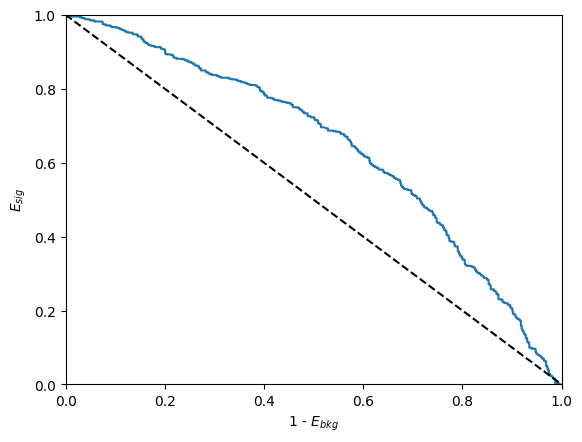

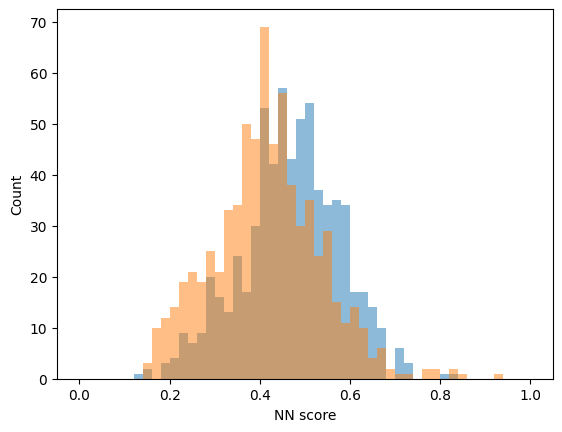

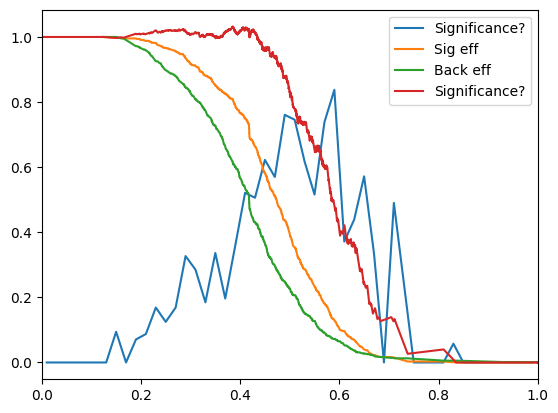

Maximum significance of 0.83762162014752 occurs at nn = 0.5900000035762787


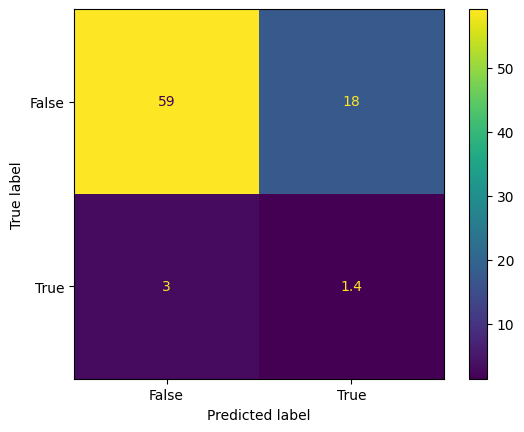

In [129]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn import preprocessing

# nn_model = keras.models.load_model('nn_model.h5')
# y_scores = nn_model.predict(scaled_test_df)
y_pred = np.round(y_scores)

# nn_model.summary()

nn_signal_scores = y_scores[test_class == 1]
nn_background_scores = y_scores[test_class == 0]

nn_fakes, nn_reals, thresholds = roc_curve(test_class, y_scores)

print(thresholds)

#print("NN AUC: ", auc(nn_fakes, nn_reals))

# nn_loss_plot = plot_loss(nn_fit)
# nn_accuracy_plot = plot_accuracy(nn_fit)

# plot_roc_curve(nn_fakes, nn_reals)

# plot signal and background scores
# plt.plot(nn_fakes, nn_reals, label="NN")
# plt.legend()
# plt.show()

# , weights=test_weight[test_class == 1]
# , weights=test_weight[test_class == 0]

plt.plot(1 - nn_fakes, nn_reals)
plt.xlabel('1 - $E_{bkg}$')
plt.ylabel('$E_{sig}$')
plt.plot([0, 1], [1, 0], 'k--')
plt.axis([0, 1, 0, 1])
plt.show()

#plot signal and background scores
entries, bin_edges, c = plt.hist(nn_signal_scores, bins=50, range = (0, 1), alpha = 0.5, label='signal')
entries1, bin_edges1, c1 = plt.hist(nn_background_scores, bins=50, range = (0, 1), alpha = 0.5, label='background')
plt.xlabel('NN score')
plt.ylabel('Count')
# plt.yscale('log')
plt.show()

entries = preprocessing.normalize([entries])[0]
entries1 = preprocessing.normalize([entries1])[0]

# hold the significance values for the entries of the signal and background arrays
significance = np.zeros(entries.size)
# sig 2?
significance2 = np.zeros(thresholds.size + 2)
# holds the center of bins which will 
bin_centers = np.zeros(entries.size)

for i in range(entries.size):
    if(entries1[i]!= 0):
        significance[i] = entries[i] / np.sqrt(entries1[i])
    bin_centers[i] = (bin_edges[i] + bin_edges[i + 1]) / 2

significance2[significance2.size - 1] = 1
for i in range(thresholds.size):
    if(nn_fakes[i] != 0):
        significance2[i + 1] = nn_reals[i] / np.sqrt(nn_fakes[i])

thresholds2 = np.insert(thresholds, 0, 1)
thresholds2 = np.append(thresholds2, 0)

plt.plot(bin_centers, significance, label = "Significance?")
plt.plot(thresholds, nn_reals, label = "Sig eff")
plt.plot(thresholds, nn_fakes, label = "Back eff")
plt.plot(thresholds2, significance2, label = "Significance?")
plt.xlim([0, 1])
plt.legend()
plt.show()

# plt.plot(bin_centers, significance, color = 'b')
# plt.plot(bin_centers, entries, '--')
# plt.plot(bin_centers, entries1, '--')
# plt.show()

print(f'Maximum significance of {np.max(significance)} occurs at nn = {bin_centers[np.where(significance == np.max(significance))][0]}')

# plt.hist(nn_signal_scores, bins=20, alpha = 0.5, label='background')
# plt.xlim([0, 1])
# # plt.yscale('log')
# plt.show()

#sum of weights
# print(sum(entries * np.diff(bin_edges)))
# print(sum(entries1 * np.diff(bin_edges1)))

#plot confusion matrix
confmatrix = confusion_matrix(test_class, y_pred, sample_weight=test_weight)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confmatrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [8]:
bdt_model = boosted_decision_tree()

bdt_fit = bdt_model.fit(scaled_train_df, train_class, batch_size=256, validation_data=(scaled_val_df, val_class), sample_weight=pd.Series(train_weight).to_frame('weight'), callbacks=[early_stopping, cp_callback])

bdt_y_scores = bdt_model.predict(scaled_test_df)

Use /tmp/tmps9vi42c1 as temporary training directory


Reading training dataset...
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Training dataset read in 0:00:07.861539. Found 4383 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(1096, shape=(), dtype=int32)
Validation dataset read in 0:00:00.649800. Found 1096 examples.
Training model...


2022-12-09 14:29:12.091631: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1765] Subsample hyperparameter given but sampling method does not match.
2022-12-09 14:29:12.091772: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1778] GOSS alpha hyperparameter given but GOSS is disabled.
2022-12-09 14:29:12.091791: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1787] GOSS beta hyperparameter given but GOSS is disabled.
2022-12-09 14:29:12.091802: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1799] SelGB ratio hyperparameter given but SelGB is disabled.
2022-12-09 14:29:12.096717: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:451] Default loss set to BINOMIAL_LOG_LIKELIHOOD
2022-12-09 14:29:12.096943: I external/ydf/yggdrasil_decision_

Model trained in 0:00:02.181947
Compiling model...


2022-12-09 14:29:14.157448: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1567] Create final snapshot of the model at iteration 91
2022-12-09 14:29:14.171567: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:247] Truncates the model to 62 tree(s) i.e. 62  iteration(s).
2022-12-09 14:29:14.172153: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:309] Final model num-trees:62 valid-loss:0.835905 valid-accuracy:0.822080
[INFO 2022-12-09T14:29:14.218472822-05:00 kernel.cc:1175] Loading model from path /tmp/tmps9vi42c1/model/ with prefix 7cd11d84c42344a2
[INFO 2022-12-09T14:29:14.23512086-05:00 abstract_model.cc:1306] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2022-12-09T14:29:14.23519969-05:00 kernel.cc:1021] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.

Epoch 1: saving model to checkpoint.ckpt
43/43 [==============================] - 0s 6ms/step


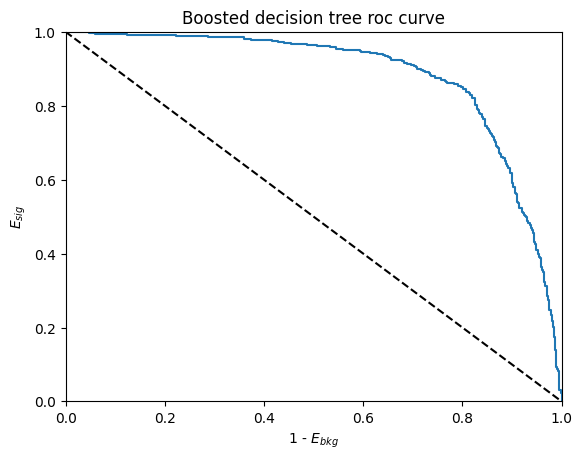

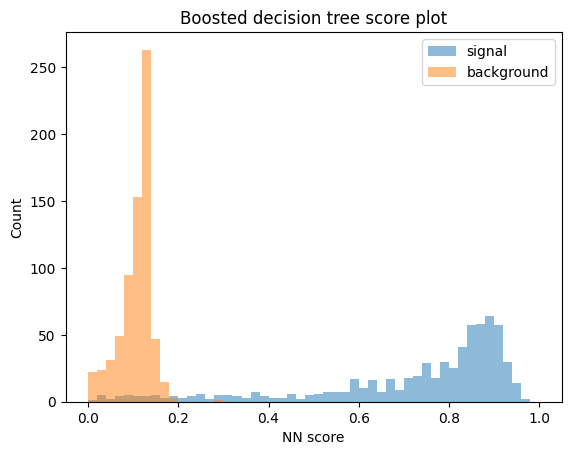

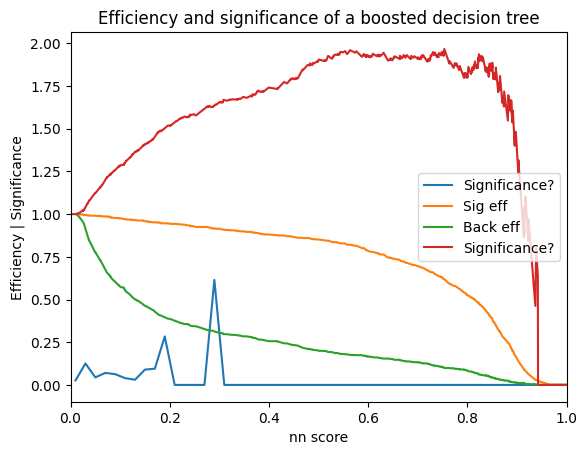

Maximum significance of 0.6145372968446344 occurs at nn = 0.2900000065565109


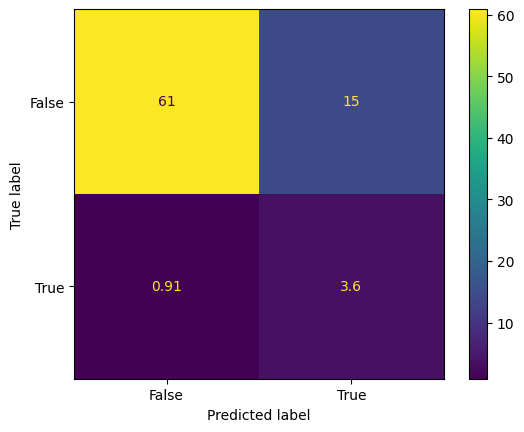

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn import preprocessing

bdt_y_pred = np.round(bdt_y_scores)

# bdt_model.summary()

bdt_nn_signal_scores = bdt_y_scores[test_class == 1]
bdt_nn_background_scores = bdt_y_scores[test_class == 0]

bdt_nn_signal_weights = test_weight[test_class == 1]
bdt_nn_background_scores = test_weight[test_class == 0]

bdt_nn_fakes, bdt_nn_reals, bdt_thresholds = roc_curve(test_class, bdt_y_scores)

# print("NN AUC: ", auc(nn_fakes, nn_reals))

# plot_roc_curve(nn_fakes, nn_reals)

plt.plot(1 - bdt_nn_fakes, bdt_nn_reals)
plt.title("Boosted decision tree roc curve")
plt.xlabel('1 - $E_{bkg}$')
plt.ylabel('$E_{sig}$')
plt.plot([0, 1], [1, 0], 'k--')
plt.axis([0, 1, 0, 1])
plt.show()

#plot signal and background scores
bdt_entries, bdt_bin_edges, bdt_c = plt.hist(bdt_nn_signal_scores, bins=50, range = (0, 1), alpha = 0.5, label='signal')
bdt_entries1, bdt_bin_edges1, bdt_c1 = plt.hist(bdt_nn_background_scores, bins=50, range = (0, 1), alpha = 0.5, label='background')
plt.title("Boosted decision tree score plot")
plt.xlabel('NN score')
plt.ylabel('Count')
plt.legend()
# plt.yscale('log')
plt.show()

bdt_entries = preprocessing.normalize([bdt_entries])[0]
bdt_entries1 = preprocessing.normalize([bdt_entries1])[0]

# hold the significance values for the entries of the signal and background arrays
bdt_significance = np.zeros(bdt_entries.size)
# holds the center of bins which will 
bdt_bin_centers = np.zeros(bdt_entries.size)
bdt_significance2 = np.zeros(bdt_thresholds.size + 2)

for i in range(bdt_entries.size):
    if(bdt_entries1[i]!= 0):
        bdt_significance[i] = bdt_entries[i] / np.sqrt(bdt_entries1[i])
    bdt_bin_centers[i] = (bdt_bin_edges[i] + bdt_bin_edges[i + 1]) / 2

bdt_significance2[bdt_significance2.size - 1] = 1
for i in range(bdt_thresholds.size):
    if(bdt_nn_fakes[i] != 0):
        bdt_significance2[i + 1] = bdt_nn_reals[i] / np.sqrt(bdt_nn_fakes[i])

bdt_thresholds2 = np.insert(bdt_thresholds, 0, 1)
bdt_thresholds2 = np.append(bdt_thresholds2, 0)

plt.plot(bdt_bin_centers, bdt_significance, label = "Significance?")
plt.plot(bdt_thresholds, bdt_nn_reals, label = "Sig eff")
plt.plot(bdt_thresholds, bdt_nn_fakes, label = "Back eff")
plt.plot(bdt_thresholds2, bdt_significance2, label = "Significance?")
plt.xlabel("nn score")
plt.ylabel("Efficiency | Significance")
plt.title("Efficiency and significance of a boosted decision tree")
plt.xlim([0, 1])
plt.legend()
plt.show()

# plt.plot(bin_centers, significance, color = 'b')
# plt.plot(bin_centers, entries, '--')
# plt.plot(bin_centers, entries1, '--')
# plt.show()

print(f'Maximum significance of {np.max(bdt_significance)} occurs at nn = {bdt_bin_centers[np.where(bdt_significance == np.max(bdt_significance))][0]}')

#sum of weights
# print(sum(entries * np.diff(bin_edges)))
# print(sum(entries1 * np.diff(bin_edges1)))

#plot confusion matrix
bdt_confmatrix = confusion_matrix(test_class, bdt_y_pred, sample_weight=test_weight)
bdt_cm_display = ConfusionMatrixDisplay(confusion_matrix = bdt_confmatrix, display_labels = [False, True])
bdt_cm_display.plot()
plt.show()

In [10]:
rft_model = random_forest_tree()

rft_fit = rft_model.fit(scaled_train_df, train_class, batch_size=256, validation_data=(scaled_val_df, val_class), sample_weight=pd.Series(train_weight).to_frame('weight'), callbacks=[early_stopping, cp_callback])

rft_y_scores = rft_model.predict(scaled_test_df)

Use /tmp/tmpr6ebj2u6 as temporary training directory


Reading training dataset...
Training dataset read in 0:00:01.048148. Found 4383 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(1096, shape=(), dtype=int32)
Validation dataset read in 0:00:00.802741. Found 1096 examples.
Training model...


[INFO 2022-12-09T14:44:53.592023825-05:00 kernel.cc:1175] Loading model from path /tmp/tmpr6ebj2u6/model/ with prefix 9311807119614d95


Model trained in 0:00:04.322829
Compiling model...


[INFO 2022-12-09T14:44:55.186803342-05:00 abstract_model.cc:1306] Engine "RandomForestOptPred" built
[INFO 2022-12-09T14:44:55.186956694-05:00 kernel.cc:1021] Use fast generic engine


Model compiled.

Epoch 1: saving model to checkpoint.ckpt
43/43 [==============================] - 1s 11ms/step


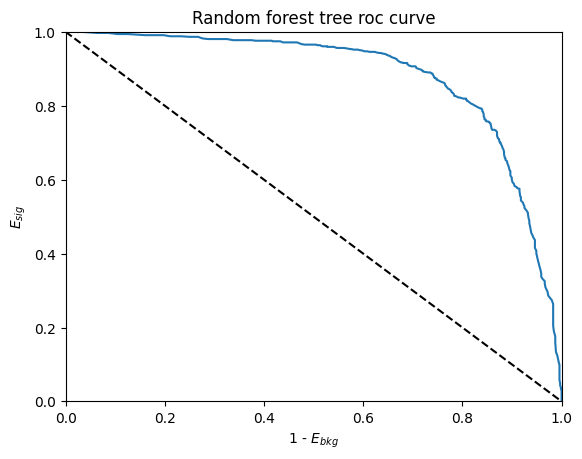

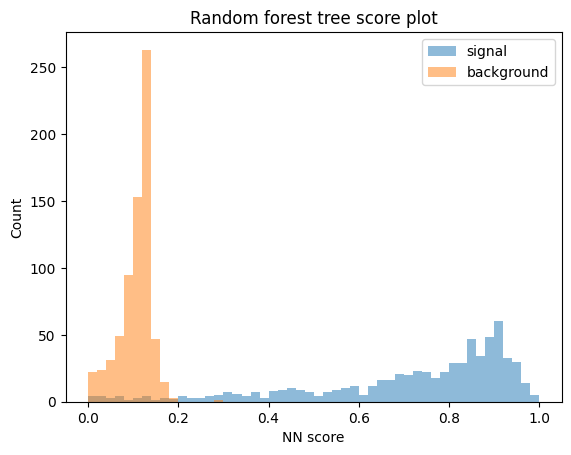

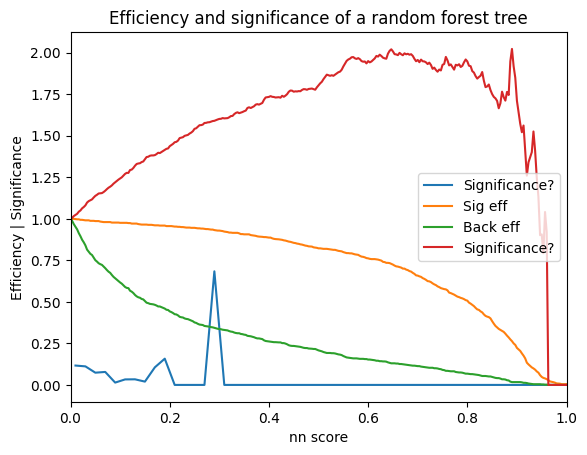

Maximum significance of 0.6839747659912171 occurs at nn = 0.2900000065565109


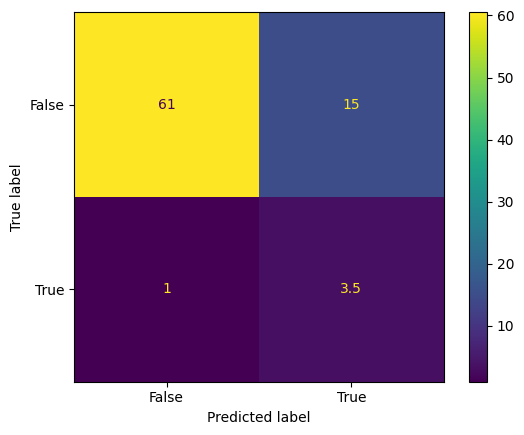

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn import preprocessing

rft_y_pred = np.round(rft_y_scores)

# rft_model.summary()

rft_nn_signal_scores = rft_y_scores[test_class == 1]
rft_nn_background_scores = rft_y_scores[test_class == 0]

rft_nn_signal_weights = test_weight[test_class == 1]
rft_nn_background_scores = test_weight[test_class == 0]

rft_nn_fakes, rft_nn_reals, rft_thresholds = roc_curve(test_class, rft_y_scores)

# print("NN AUC: ", auc(nn_fakes, nn_reals))

# plot_roc_curve(nn_fakes, nn_reals)

plt.plot(1 - rft_nn_fakes, rft_nn_reals)
plt.title("Random forest tree roc curve")
plt.xlabel('1 - $E_{bkg}$')
plt.ylabel('$E_{sig}$')
plt.plot([0, 1], [1, 0], 'k--')
plt.axis([0, 1, 0, 1])
plt.show()

#plot signal and background scores
rft_entries, rft_bin_edges, rft_c = plt.hist(rft_nn_signal_scores, bins=50, range = (0, 1), alpha = 0.5, label='signal')
rft_entries1, rft_bin_edges1, rft_c1 = plt.hist(rft_nn_background_scores, bins=50, range = (0, 1), alpha = 0.5, label='background')
plt.title("Random forest tree score plot")
plt.xlabel('NN score')
plt.ylabel('Count')
plt.legend()
# plt.yscale('log')
plt.show()

rft_entries = preprocessing.normalize([rft_entries])[0]
rft_entries1 = preprocessing.normalize([rft_entries1])[0]

# hold the significance values for the entries of the signal and background arrays
rft_significance = np.zeros(rft_entries.size)
# holds the center of bins which will 
rft_bin_centers = np.zeros(rft_entries.size)
rft_significance2 = np.zeros(rft_thresholds.size + 2)

for i in range(rft_entries.size):
    if(rft_entries1[i]!= 0):
        rft_significance[i] = rft_entries[i] / np.sqrt(rft_entries1[i])
    rft_bin_centers[i] = (rft_bin_edges[i] + rft_bin_edges[i + 1]) / 2

rft_significance2[rft_significance2.size - 1] = 1
for i in range(rft_thresholds.size):
    if(rft_nn_fakes[i] != 0):
        rft_significance2[i + 1] = rft_nn_reals[i] / np.sqrt(rft_nn_fakes[i])

rft_thresholds2 = np.insert(rft_thresholds, 0, 1)
rft_thresholds2 = np.append(rft_thresholds2, 0)

plt.plot(rft_bin_centers, rft_significance, label = "Significance?")
plt.plot(rft_thresholds, rft_nn_reals, label = "Sig eff")
plt.plot(rft_thresholds, rft_nn_fakes, label = "Back eff")
plt.plot(rft_thresholds2, rft_significance2, label = "Significance?")
plt.xlabel("nn score")
plt.ylabel("Efficiency | Significance")
plt.title("Efficiency and significance of a random forest tree")
plt.xlim([0, 1])
plt.legend()
plt.show()

# plt.plot(bin_centers, significance, color = 'b')
# plt.plot(bin_centers, entries, '--')
# plt.plot(bin_centers, entries1, '--')
# plt.show()

print(f'Maximum significance of {np.max(rft_significance)} occurs at nn = {rft_bin_centers[np.where(rft_significance == np.max(rft_significance))][0]}')

#sum of weights
# print(sum(entries * np.diff(bin_edges)))
# print(sum(entries1 * np.diff(bin_edges1)))

#plot confusion matrix
rft_confmatrix = confusion_matrix(test_class, rft_y_pred, sample_weight=test_weight)
rft_cm_display = ConfusionMatrixDisplay(confusion_matrix = rft_confmatrix, display_labels = [False, True])
rft_cm_display.plot()
plt.show()

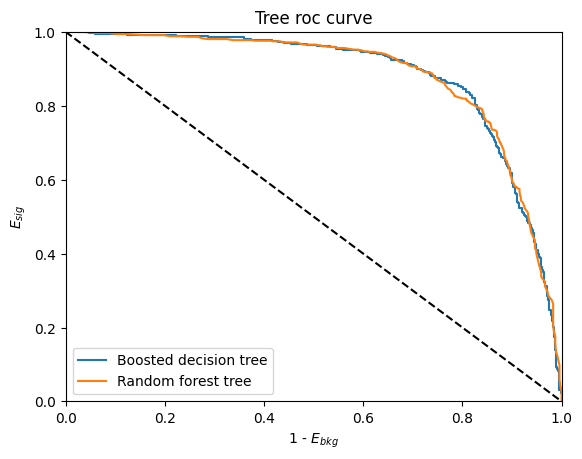

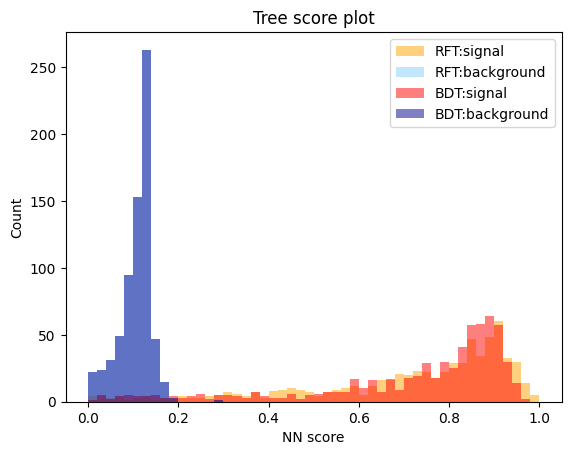

In [13]:
plt.plot(1 - bdt_nn_fakes, bdt_nn_reals, label = "Boosted decision tree")
plt.plot(1 - rft_nn_fakes, rft_nn_reals, label = "Random forest tree")
plt.title("Tree roc curve")
plt.xlabel('1 - $E_{bkg}$')
plt.ylabel('$E_{sig}$')
plt.plot([0, 1], [1, 0], 'k--')
plt.axis([0, 1, 0, 1])
plt.legend()
plt.show()

#plot signal and background scores
rft_entries, rft_bin_edges, rft_c = plt.hist(rft_nn_signal_scores, bins=50, range = (0, 1), alpha = 0.5, label='RFT:signal', color = 'orange')
rft_entries1, rft_bin_edges1, rft_c1 = plt.hist(rft_nn_background_scores, bins=50, range = (0, 1), alpha = 0.5, label='RFT:background', color = 'lightskyblue')
bdt_entries, bdt_bin_edges, bdt_c = plt.hist(bdt_nn_signal_scores, bins=50, range = (0, 1), alpha = 0.5, label='BDT:signal', color = 'red')
bdt_entries1, bdt_bin_edges1, bdt_c1 = plt.hist(bdt_nn_background_scores, bins=50, range = (0, 1), alpha = 0.5, label='BDT:background', color = "darkblue")
plt.title("Tree score plot")
plt.xlabel('NN score')
plt.ylabel('Count')
plt.legend()
# plt.yscale('log')
plt.show()